In [1]:
from Neural_Nets.LaengeNet.Development.LaengeNetTorch import LaengeNet, LaengeNetLossFunc, LaengeDataset
from Neural_Nets.ThermoNetActFuncs.Development.ThermoNetActFuncs import Sigmoid
from Utils.PlotHandler.Development.PlotHandler import PlotHandler 
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Rprop
from Data_Handling.SGTEHandler.Development.SGTEHandler import SGTEHandler
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def epoch(net: LaengeNet, dataloader, loss_func, optimizer):
    epoch_losses = np.zeros([len(dataloader), ])

    for i, (temp, g, s, h, c) in enumerate(dataloader):
        temp = temp.unsqueeze(-1)
        
        # Input scaling 
        #temp /= temp.max()

        # Forward pass
        gibbs_energy, entropy, enthalpy, heat_cap = net(temp, temp, temp, temp, debug=True)
        
        # Output scaling
        scale = 1
        gibbs_energy, entropy, enthalpy, heat_cap = gibbs_energy/scale, entropy/scale, enthalpy/scale, heat_cap/scale
        g, s, h, c = g/scale, s/scale, h/scale, c/scale
        
        # Get the loss
        loss = loss_func(gibbs_energy.float(), g.float(), entropy.float(), s.float(), enthalpy.float(), h.float(),
                         heat_cap.float(), c.float(), debug=False)

        # Backward pass
        net.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 100)
        optimizer.step()
        epoch_losses[i] = loss

    mean_epoch_loss = epoch_losses.mean()
    print('Mean epoch loss: ', mean_epoch_loss)
    return mean_epoch_loss

In [ ]:
def train(net, dataset):
    # Hyperparameters
    n_epochs = 100
    lr = 0.1
    batch_size = 128
    std_thresh = 0.05
    loss_weights = [1, 0, 0, 0]

    # Data
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Optimizer
    optimizer = Rprop(net.parameters(), lr=lr)
    loss_func = LaengeNetLossFunc(loss_weights)

    losses = []
    
    # Keep track of epoch where learning rate was reduced last
    lr_reduced_last = 0

    for i in range(n_epochs):
        print('-----\nEpoch %i:\n' % i)
        loss = epoch(net, dataloader, loss_func, optimizer)
        losses.append(loss)
        
        # Adapt learning rate if standard deviation over the last 10 epochs is below a threshold
        if np.array(losses[-10:]).std() < std_thresh and (i - lr_reduced_last) >= 10:
            print('Learning rate halfed! \n')
            lr_reduced_last = i
            lr /= 2

In [ ]:
net = LaengeNet(init_args=(0.5, 1), act_1=Sigmoid())

element = 'Fe'
phase = ['BCC_A2']
dataset = LaengeDataset(element, phase)

train(net, dataset)

In [ ]:
print('theta_E: ', net.sub_net_1.act_1.theta_E)
print('E0: ', net.sub_net_1.act_1.E0)
print('a: ', net.sub_net_1.act_1.a)
print('b: ', net.sub_net_1.act_1.b)

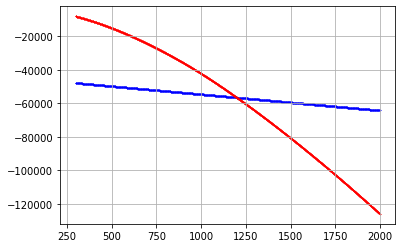

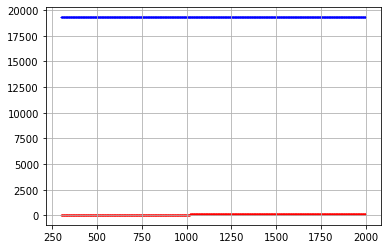

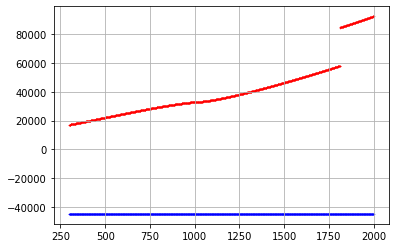

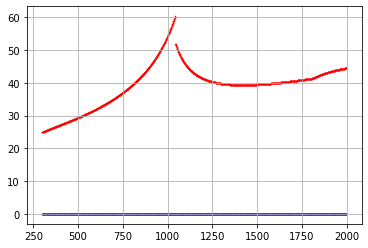

In [53]:
ph = PlotHandler()

ph.properties_temp(net, dataset)

In [ ]:
#torch.save(net, 'LaengeNet/Models/model_12_01_22_1535')